# Project: Boston Housing Analysis

This project trains and tests a model using housing information in Boston Distrct. It proves to be of value for agents to have this kind of model.
Recorded since 1978, the datasets contain 506 data points, with 14 characteristics for diverse houses.    

## 1. Import necessary data, packages, and functions

The data has been processed as follows:
* 16 data points with `MEDV == 50.0` has been removed, possibly for loss or unseen value.
* 1 data point with `RM == 8.78` has been removed for possible error.
* For this project, we will focus on `RM`, `LSTAT`, `PTRATIO` and `MEDV`, while `MEDV` has taken inflation in account.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

%matplotlib inline

data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


## 2. Analyse data

In this section, we will have a slight observation of the housing data and give some analysis. With exploration and familiarity, we can better understand and explain the results.   

Since the target is to build a model for price prediction we will divide datasets into **features** and **target variable**:
* Features: `RM`, `LSTAT`, `PTRATTO`, which provides the information.
* Target Variable: `MEDV`, the one we wish to predict. 

They're separately saved in `features` and `prices`.

First, we will have an intuitive recognition of these varaibles:
* `RM` refers to the average room number each house in the district.
* `LSTAT` refers to the percentage of the resident in low-income class.
* `PTRATIO` refers to the propotion of student to teachers in the district.  

Intuitively, **higher** `RM`, **lower** `LSTAT` and **lower** `PTRATIO` will result in a **higher** `MEDV`.


Then, we use `Numpy` to calculate some simple but necessary statistics.

In [2]:
# Calculate necessary statistics
minimum_price = np.min(data)
maximum_price = np.max(data)
mean_price = np.mean(data)
median_price = np.median(data)
std_price = np.std(data)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:.2f}".format(minimum_price)) 
print("Maximum price: ${:.2f}".format(maximum_price))
print("Mean price: ${:.2f}".format(mean_price))
print("Median price ${:.2f}".format(median_price))
print("Standard deviation of prices: ${:.2f}".format(std_price.iloc[0]))

Statistics for Boston housing dataset:

Minimum price: $1.98
Maximum price: $1024800.00
Mean price: $113595.16
Median price $17.27
Standard deviation of prices: $0.64


## 3. Build the model

First, we have to set an standard for evaluation. In this project, we prefer the *coefficient of determination*, i.e. $R^2$. It is a very frequently-used statistics, often as a standard for prediction.
* For $R^2$ = 0, the model is less effective than that using mean value.
* For $R^2$ ranging from 0 to 1, this indicates how much of the target variable could be explained with **characteristics**.
* Sometimes for $R^2$ < 0, the model is much less effective then that using mean value.

In [3]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the R^2 score between y_true and y_predict
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

For example, here is a test for the function:

In [4]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], 
                           [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination R^2, of {:.3f}.".format(score))

Model has a coefficient of determination R^2, of 0.923.


Then we will divide the whole datasets into trainsets and testsets, as this division could solve the problem of **overfitting** well.   
Often in this process, data is re-arranged as well, in case of the bias caused by the order:
* Devide the data into two parts: 80% for training, 20% for test.
* Unify the `random_state` for result in accordance.
* Assign trainsets and testsets to corresponding variables.

In [5]:
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


## 4. Analyse model performance

Here comes the *learning curve* of a decision tree with pruning. The 4 plots below shows different performances of a **decision tree** for different max-depth.

It shows clearly the $R^2$ score for the trainset and testset, **with data volume increasing**. The shadow indicates uncertainty using $\sigma$.

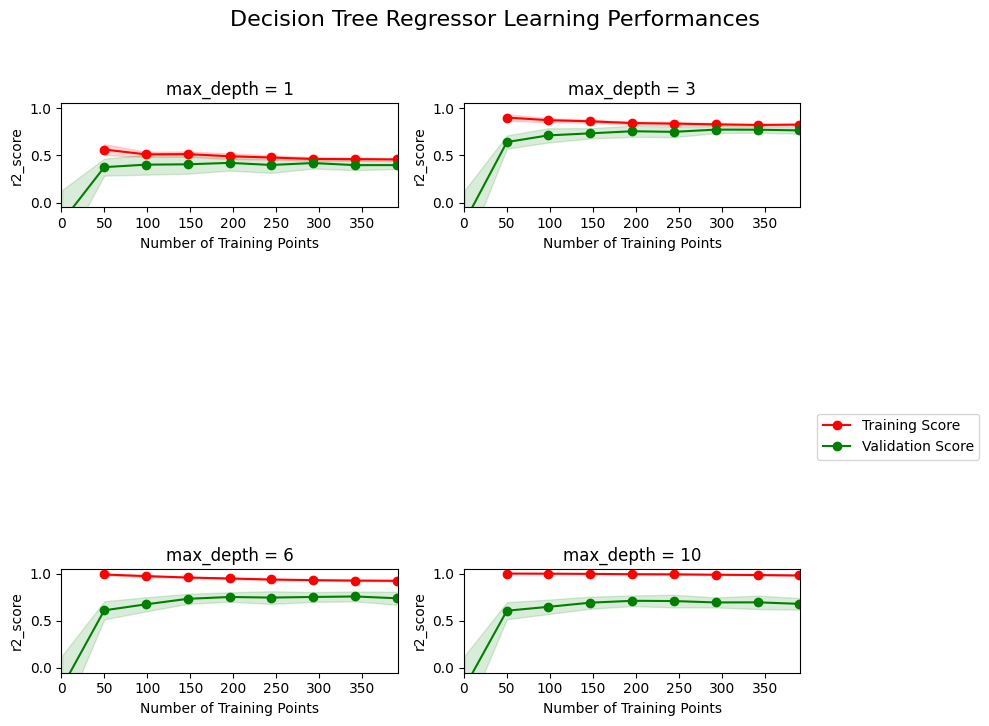

In [6]:
import warnings
from IPython import get_ipython
import matplotlib.pyplot as pl
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split

warnings.filterwarnings("ignore")
get_ipython().run_line_magic('matplotlib', 'inline')

def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and validation scores for each model are then plotted. 
    """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)


    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([1,3,6,10]):
        
        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, valid_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        valid_std = np.std(valid_scores, axis = 1)
        valid_mean = np.mean(valid_scores, axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, valid_mean, 'o-', color = 'g', label = 'Validation Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, valid_mean - valid_std, \
            valid_mean + valid_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('r2_score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()


# Produce learning curves for varying training set sizes and maximum depths
ModelLearning(features, prices)

Here comes the *complexity curve*, indicating the **uncertainty** of the curve. Here is the tip:
* **High bias** indicates under-fitting, e.g. the model is too simple.
* **High variance** indicates overfitting, such that it is difficult to *generalize*.



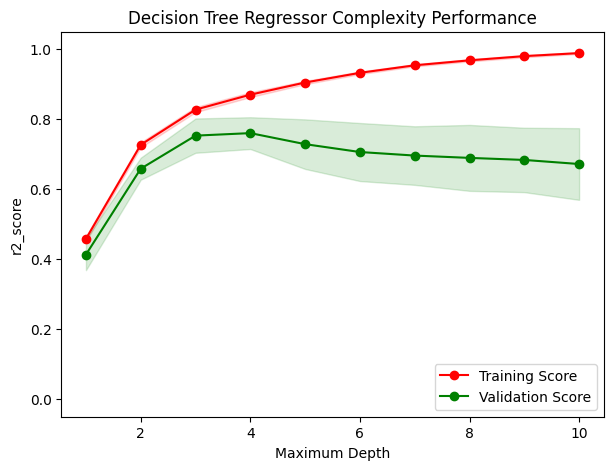

In [7]:
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and validation errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot the validation curve
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')
    pl.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    pl.plot(max_depth, valid_mean, 'o-', color = 'g', label = 'Validation Score')
    pl.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    pl.fill_between(max_depth, valid_mean - valid_std, \
        valid_mean + valid_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    pl.legend(loc = 'lower right')
    pl.xlabel('Maximum Depth')
    pl.ylabel('r2_score')
    pl.ylim([-0.05,1.05])
    pl.show()

# Produce complexity curves for varying training set sizes and maximum depths
ModelComplexity(X_train, y_train)


## 5. Evaluate model performance

Here we will combine and train a model with a **decision tree**.
To optimize the model, we use the *grid search* and *k-fold cross-validation*.
* *Grid search* is used to find the optimal `max_depth` parameter. As the decision tree is one of the **supervised learning algorithm**, `max_depth` is like, number of "questions"  raised to data before prediction.
* *Cross-validation* is used to assess the **performance** and **generalization** ability of a model, reducing the potential bias introduced by using a single train-test split.


In [8]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.20, random_state=42)
    
    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': range(1, 11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer'
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_


In this way, we could find the optimal model.

In [9]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 3 for the optimal model.


Here is an example for test:

In [10]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $345,707.55
Predicted selling price for Client 2's home: $260,645.00
Predicted selling price for Client 3's home: $903,393.75


We find that the prediction for the three is reasonable. Expand it to the whole:

In [11]:
# Use the optimal model to predict on the whole testset
y_pred = reg.predict(X_test)
with open('predictions.txt', 'w') as f:
    for pred in y_pred:
        f.write(str(pred) + '\n')

# Calculate R^2
r2 = performance_metric(y_test, y_pred)

print("Optimal model has R^2 score: {:.2f}".format(r2))

Optimal model has R^2 score: 0.77


A optimal model is not always the most robust one, for the reason like:
* Sometimes the model is too complex or simple, hard to add new data.
* Sometimes the algorithm is not that adaptable.
* Sometimes the sample itself is not enough in scale, or has too much noise.

Under these circumstances, the model is *under-fitting*.

If we use diverse trainsets and testsets to train the model for 10 times, the outcome acts like follows:

In [12]:
def PredictTrials(X, y, fitter, data):
    """ Performs trials of fitting and predicting data. """

    # Store the predicted prices
    prices = []

    for k in range(10):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)
        
        # Fit the data
        reg = fitter(X_train, y_train)
        
        # Make a prediction
        pred = reg.predict([data[0]])[0]
        prices.append(pred)
        
        # Result
        print("Trial {}: ${:,.2f}".format(k+1, pred))

    # Display price range
    print("\nRange in prices: ${:,.2f}".format(max(prices) - min(prices)))

PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $411,417.39
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $413,334.78
Trial 6: $411,931.58
Trial 7: $390,250.00
Trial 8: $407,232.00
Trial 9: $402,531.82
Trial 10: $413,700.00

Range in prices: $30,372.22


## 6. More

Simply discuss the model, we have further problems like:

* The data collected in 1978 may not be applicable today due to factors such as inflation affecting the real estate market.
* The features presented in the data are not sufficient to fully describe a house, and there are other factors to consider.
* The data collected in Boston may not directly apply to other rural areas, as the real estate market varies across different regions.
* Relying solely on the neighborhood's environment to determine housing value may not be accurate enough, as more factors need to be considered.

Only with more powerful models and much more detailed data could we do a better job, and it is well worth exploration.